In [71]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.Polypeptide import one_to_three

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

In [4]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


def get_A_B(pre, n=201, first_half=False, second_half=False,):
    # pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_3/gamma_mode_3"
    A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
    B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
    A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
    # half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
    # other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
    # std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)
#     A = A[:n]
#     B = B[:n,:n]
#     A_prime = A_prime[:n]
#     half_B = half_B[:n,:n]
#     other_half_B = other_half_B[:n, :n]
#     std_half_B = std_half_B[:n, :n]
    if second_half:
        half_n = int(n/2)
        A = A[half_n:]
        B = B[half_n:,half_n:]
        A_prime = A_prime[half_n:]
        # half_B = half_B[half_n:,half_n:]
        # other_half_B = other_half_B[half_n:, half_n:]
        # std_half_B = std_half_B[half_n:, half_n:]
    A_B_dic = {}
    A_B_dic["A"] = A
    A_B_dic["B"] = B
    # A_B_dic["half_B"] = half_B
    # A_B_dic["other_half_B"] = other_half_B
    # A_B_dic["std_half_B"] = std_half_B
    A_B_dic["A_prime"] = A_prime
    return A_B_dic

def get_gamma(A, B, A_prime, c=-100, cutoff_range=range(100, 210, 10)):
    gamma_cutoff_dic = {}
    for cutoff in list(cutoff_range):
        # cutoff = 400
        lamb, P = np.linalg.eig(B)
        lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
        filtered_lamb = np.copy(lamb)
        cutoff_mode = cutoff
        filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                           cutoff_mode, P)
        B_inv = filtered_B_inv
        lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
        gamma_new = B_inv.dot(A-A_prime*lambda_2)
        gamma_cutoff_dic[cutoff] = gamma_new
    return gamma_cutoff_dic

In [118]:
def compute_z(A_B, gamma, n=-1, start=0):
    if n == -1:
        n = A_B["A"].shape[0]
    # z score
    B = A_B["B"][start:start+n,start:start+n]
    A = A_B["A"][start:start+n]
    A_prime = A_B["A_prime"][start:start+n]
    x = gamma
    # x = gamma_mode15[520]
    e_std = (np.dot(x, B).dot(x))**0.5
    z = A.dot(x) / e_std
    print(z, e_std, A.dot(x), A_prime.dot(x))
    
def filter_B_matrix(B, cutoff):
    # cutoff = 520
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    B_new = np.linalg.inv(filtered_B_inv)
    return B_new

In [67]:
# (IMV) (L) (FWY) (G) (P) (C) (A) (STNH) (RKQE) (D)
#   0    1    2    3   4   5   6     7     8     9
ten_letter_code_letters = {
    'I':0, 'M':0, 'V':0, 'L':1, 'F':2, 'W':2, 'Y':2, 'G':3, 'P':4, 'C':5, 'A':6,
    'S':7, 'T':7, 'N':7, 'H':7, 'R':8, 'K':4, 'Q':8, 'E':8, 'D':9,
}

def get_num_letter_based_index(res1_1, res1_2, n=10):
    index = ten_letter_code_letters[three_to_one(res1_1)]*n + ten_letter_code_letters[three_to_one(res1_2)]
    return index

def get_overall_index(index1, index2, direction, n):
    # if n = 400
    # times n plus 1 divide by 2 -> total parameters: 401*400/2 = 80200
    n_shift = int((n+1)*n/2)
    new_index1 = index1
    new_index2 = index2
    if new_index1 > new_index2:
        new_index1, new_index2 = new_index2, new_index1
    overall_index = ((2*n-(new_index1-1))*(new_index1)/2 + new_index2 - new_index1)
    if direction == "anti":
        overall_index += n_shift
    return int(overall_index)

def get_interaction_index_from_four_residues_v9(res1_1, res1_2, res2_1, res2_2, direction, letter_num=10):
    index1 = get_num_letter_based_index(res1_1, res1_2)
    if direction == "parallel":
        index2 = get_num_letter_based_index(res2_1, res2_2)
    elif direction == "anti":
        index2 = get_num_letter_based_index(res2_2, res2_1)
    else:
        print("unknown direction")
        raise
    index = get_overall_index(index1, index2, direction, n=100)

    return index

# Mode 23, shuffling based optimization

In [36]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/new_msa_optimization_submode_23/gamma/"
mode_23_newMSA = get_A_B(pre, n=10790)

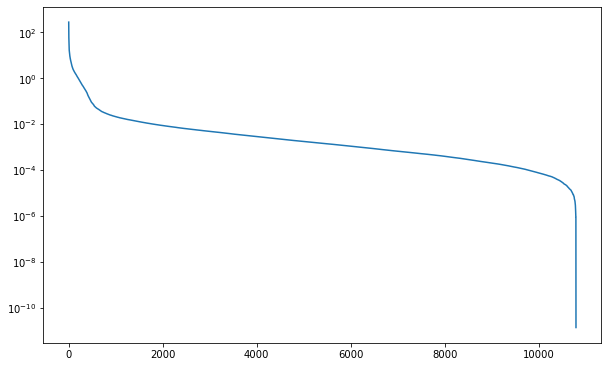

In [115]:
B = mode_23_newMSA['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [116]:
A_B = mode_23_newMSA
A = A_B['A']
B = A_B['B']
A_prime = A_B['A_prime']

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [2000, 8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23_newMSA = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [119]:
compute_z(mode_23_newMSA, gamma_mode_23_newMSA[8000])

5.998476844600862 5.987177214785081 35.91394388741019 -66.00000000000244


In [120]:
compute_z(mode_23_newMSA, gamma_mode_23_newMSA[2000])

5.382604696088895 5.157121987950886 27.758749030647735 -66.00000000000081


In [117]:
compute_z(mode_23_newMSA, gamma_mode_23_newMSA[8000])

5.998476844600862 5.987177214785081 35.91394388741019 -66.00000000000244


In [41]:
compute_z(mode_23_newMSA, gamma_mode_23_newMSA[2000])

5.382604696088895 5.157121987950886 27.758749030647735 -66.00000000000081


In [93]:
gamma_mode_23_newMSA[2000][690:][2772]

-1.251693088681819

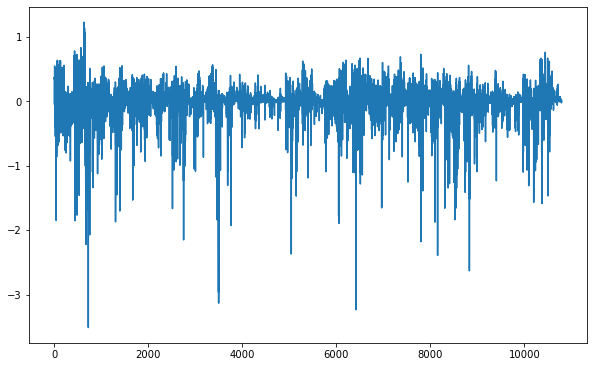

In [47]:
plt.plot(gamma_mode_23_newMSA[2000])

In [39]:
A_B = mode_23_newMSA
A = A_B['A'][:690]
B = A_B['B'][:690,:690]
A_prime = A_B['A_prime'][:690]

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [600]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23_newMSA_contact = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [45]:
compute_z(mode_23_newMSA, gamma_mode_22_newMSA_contact[600], n=690)

3.044696506518888 1.3138583836960416 4.00030003089989 -63.40532716277124


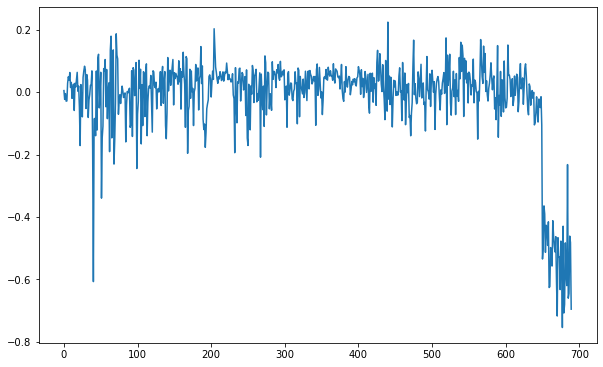

In [46]:
plt.plot(gamma_mode_22_newMSA_contact[600])

In [50]:
A_B = mode_23_newMSA
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

# cutoff_range=list(range(400, 700, 20))
# cutoff_range = [600]
cutoff_range = [2000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23_newMSA_fourbody = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

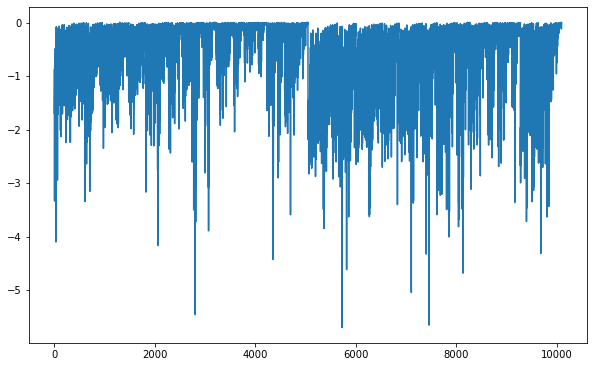

In [51]:
plt.plot(gamma_mode_23_newMSA_fourbody[2000])

In [54]:
compute_z(mode_23_newMSA, 10*gamma_mode_23_newMSA_fourbody[2000], start=690)

1.9476868363541076 71.22677052796824 138.72744335333846 -659.9999999999999


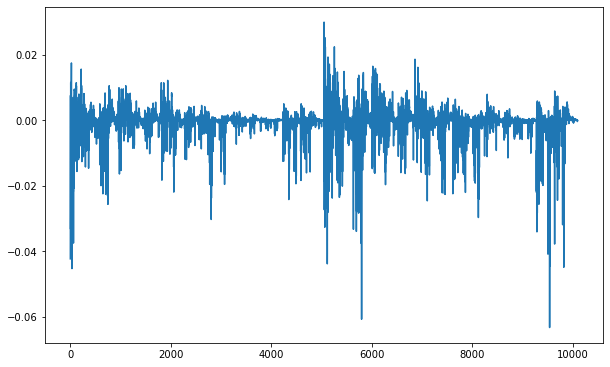

In [55]:
plt.plot(A)

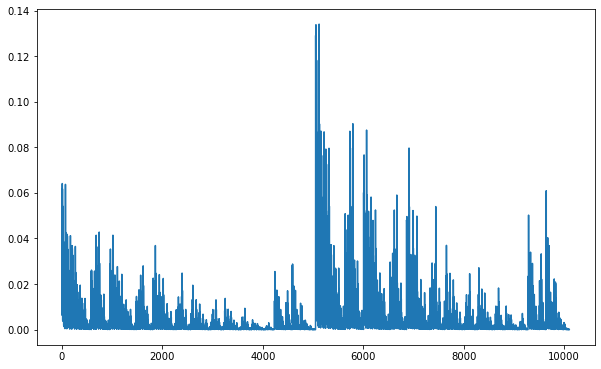

In [56]:
plt.plot(A_prime)

In [57]:
A_prime.sum()

46.37728314744647

In [58]:
A_prime.shape

(10100,)

In [60]:
mode_22_newMSA['A_prime'][690:].sum()

49.23473495500756

In [72]:
res1_1 = "GLY"
res1_2 = "GLY"
res2_1 = "GLY"
res2_2 = "GLY"
direction = "parallel"
get_interaction_index_from_four_residues_v9(res1_1, res1_2, res2_1, res2_2, direction, letter_num=10)

2772

In [75]:
res1_1 = "LEU"
res1_2 = "LEU"
res2_1 = "LEU"
res2_2 = "LEU"
direction = "parallel"
get_interaction_index_from_four_residues_v9(res1_1, res1_2, res2_1, res2_2, direction, letter_num=10)

1045

In [ ]:
# 2772 (GxxxG) is 10 times less likely to have than 5057.
# this agrees with the databse check. (GxxxG_optimization_oct24_dataset_curation_revisit)

In [99]:
mode_23_newMSA['phi_native'] = mode_23_newMSA['A_prime'] - mode_23_newMSA['A'] 

In [100]:
np.argmax(mode_23_newMSA['phi_native'][690:])

5057

In [101]:
mode_23_newMSA['phi_native'][690:][5057]

0.1575813062652817

In [102]:
mode_23_newMSA['phi_native'][690:][2772]

0.013846322607237649

In [105]:
mode_23_newMSA['phi_native'][690:][5052]

0.08798597504664656

In [ ]:
# two method achieve the same phi_native. This is good.
mode_22_newMSA['phi_native'] = mode_22_newMSA['A_prime'] - mode_22_newMSA['A'] 

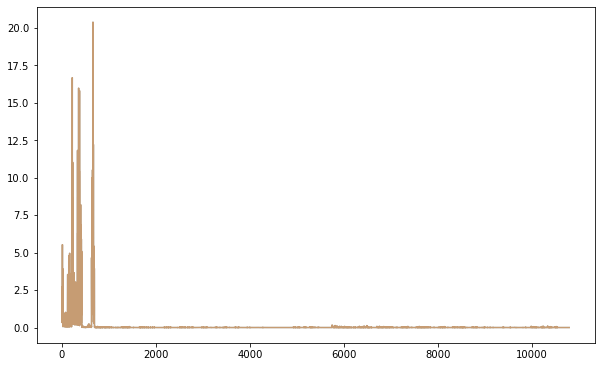

In [114]:
plt.plot(mode_22_newMSA['phi_native'], alpha=0.5)
plt.plot(mode_23_newMSA['phi_native'], alpha=0.5)

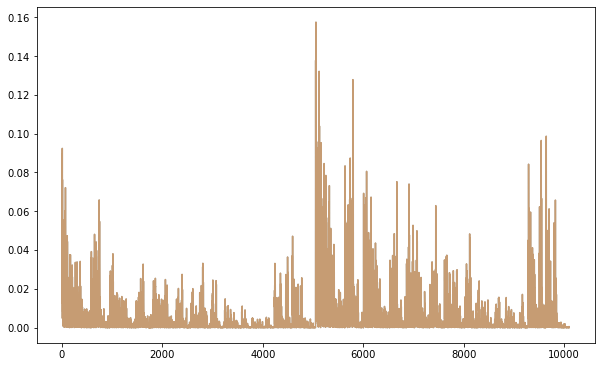

In [113]:
plt.plot(mode_22_newMSA['phi_native'][690:], alpha=0.5)
plt.plot(mode_23_newMSA['phi_native'][690:], alpha=0.5)

In [80]:
np.argmax(mode_23_newMSA['A'][690:])

5052

In [81]:
mode_23_newMSA['A'][690:][5052]

0.029987571206093886

In [83]:
np.argmin(mode_22_newMSA['A'][690:])

5799

In [82]:
np.argmin(mode_23_newMSA['A'][690:])

9542

In [97]:
np.argmax(mode_23_newMSA['A_prime'][690:])

5120

In [98]:
mode_23_newMSA['A_prime'][690:][5120]

0.13402556733938195

In [84]:
mode_22_newMSA['A'][690:][9542]

-0.022679245818360328

In [85]:
mode_23_newMSA['A'][690:][9542]

-0.06330330019330939

In [76]:
mode_22_newMSA['A'][690:][1045]

0.001085644072820104

In [77]:
mode_22_newMSA['A_prime'][690:][1045]

0.010640115645895317

In [95]:
mode_22_newMSA['A_prime'][690:][2772]

0.0066262517516337185

In [96]:
mode_23_newMSA['A_prime'][690:][2772]

0.0008426096643923701

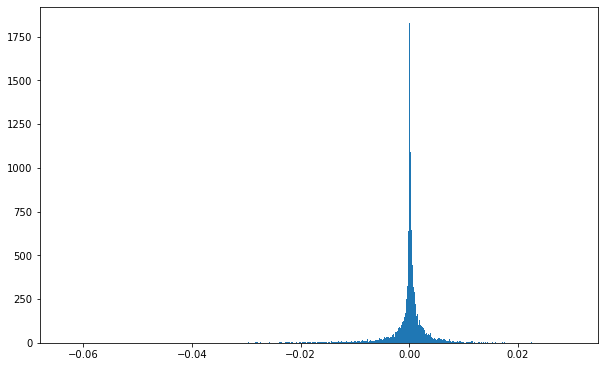

In [90]:
_ = plt.hist(mode_23_newMSA['A'][690:], bins=500)

In [78]:
mode_23_newMSA['A'][690:][2772]

-0.013003712942845278

In [73]:
mode_22_newMSA['A'][690:][2772]

-0.007220070855603929

In [74]:
mode_22_newMSA['A_prime'][690:][2772]

0.0066262517516337185

In [ ]:
mode_22_newMSA['A'][690:][2772]

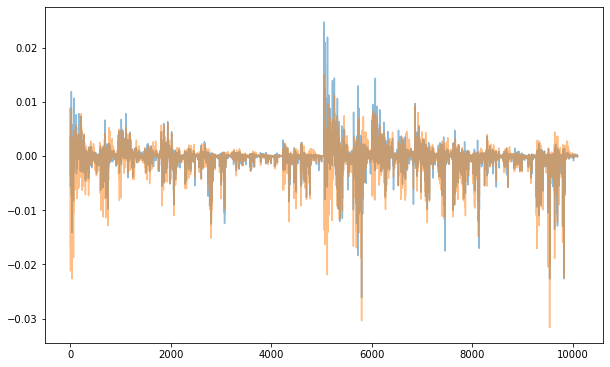

In [66]:
plt.plot(mode_22_newMSA['A'][690:], alpha=0.5)
plt.plot(0.5*mode_23_newMSA['A'][690:], alpha=0.5)

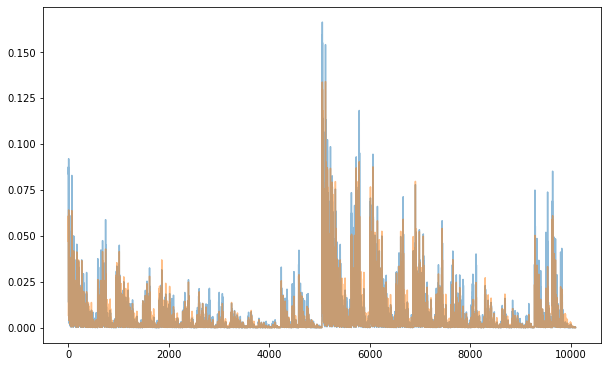

In [62]:
plt.plot(mode_22_newMSA['A_prime'][690:], alpha=0.5)
plt.plot(mode_23_newMSA['A_prime'][690:], alpha=0.5)

# New MSA, Mode 22, swapping based optimization.

In [5]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/new_msa_optimization_submode_22/gamma/"
mode_22_newMSA = get_A_B(pre, n=10790)

In [17]:
A_B = mode_22_newMSA
A = A_B['A'][:690]
B = A_B['B'][:690,:690]
A_prime = A_B['A_prime'][:690]

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [600]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22_newMSA_contact = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [18]:
x = gamma_mode_22_newMSA_contact[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.0515972456092122 1.336659257657927 1.4056271936711304 -65.99999999999999


In [15]:
A_B = mode_22_newMSA
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22_newMSA_fourbody = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [16]:
x = gamma_mode_22_newMSA_fourbody[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.5541921554503375 3.1008205060445473 1.7184503999094338 -66.00000000000001


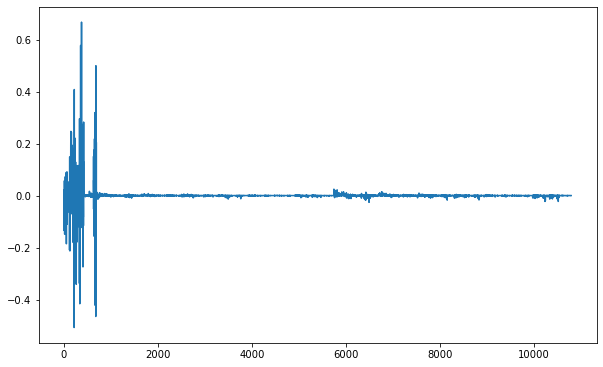

In [8]:
plt.plot(mode_22_newMSA['A'])

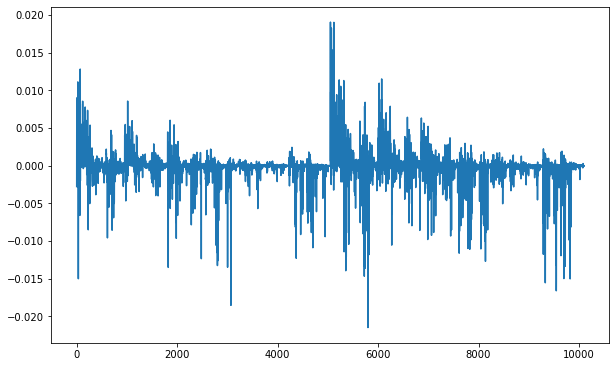

In [12]:
plt.plot(mode_22_400['A'][690:])

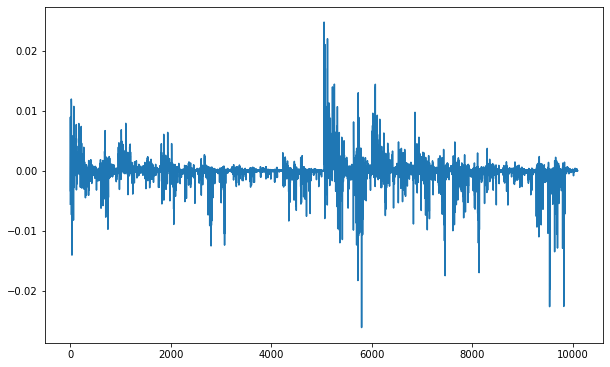

In [10]:
plt.plot(mode_22_newMSA['A'][690:])

In [13]:
A_B = mode_22_newMSA
A = A_B['A']
B = A_B['B']
A_prime = A_B['A_prime']

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [2000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22_newMSA = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [14]:
x = gamma_mode_22_newMSA[2000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3610758380832522 1.4781926425441887 2.011932289799329 -65.99999999999949


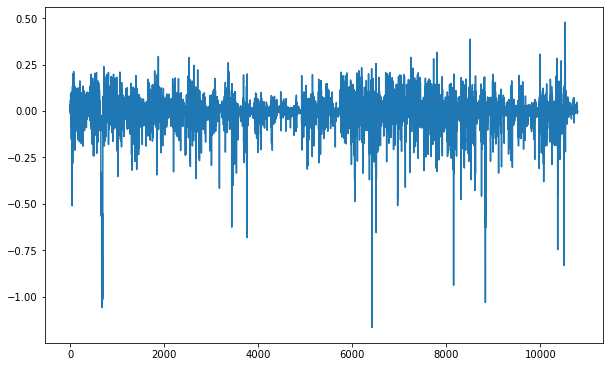

# mode 22, using ten letter code

In [9]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_22/with400_protein_gammas/"
mode_22_400 = get_A_B(pre, n=10790)

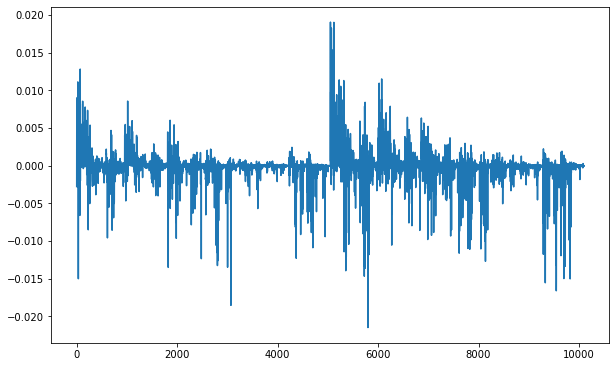

In [398]:
plt.plot(mode_22_400['A'][690:])

In [399]:
A_B = mode_22_400
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22_400 = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [401]:
x = gamma_mode_22_400[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.5773582292397449 2.8725031142987127 1.6584633115571572 -66.0


In [376]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_22/gamma/"
mode_22 = get_A_B(pre, n=10790)

In [388]:
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

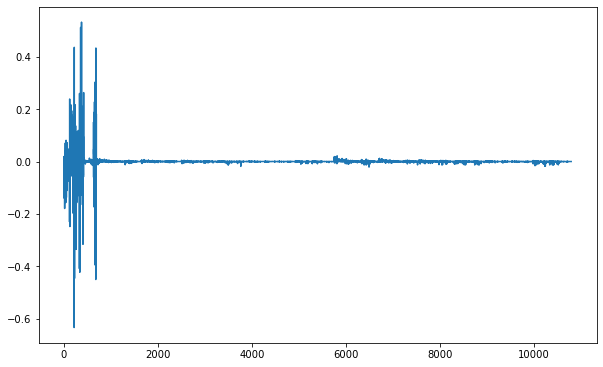

In [393]:
plt.plot(A_B['A'])

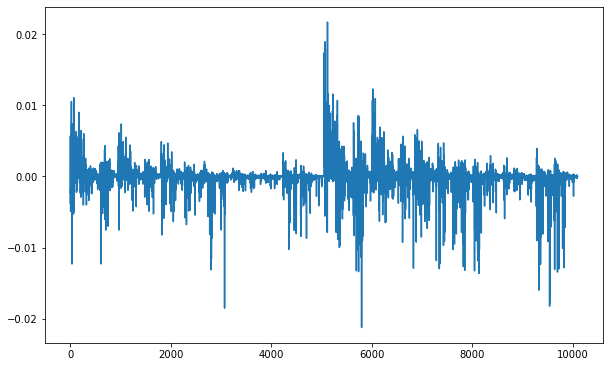

In [394]:
plt.plot(A)

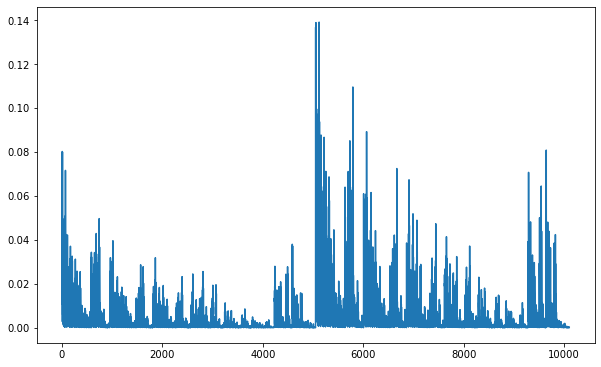

In [395]:
plt.plot(A_prime)

In [389]:
A_B = mode_22
# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22 = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [391]:
x = gamma_mode_22[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7335323632693906 2.831298185588163 2.076848849194823 -65.99999999999999


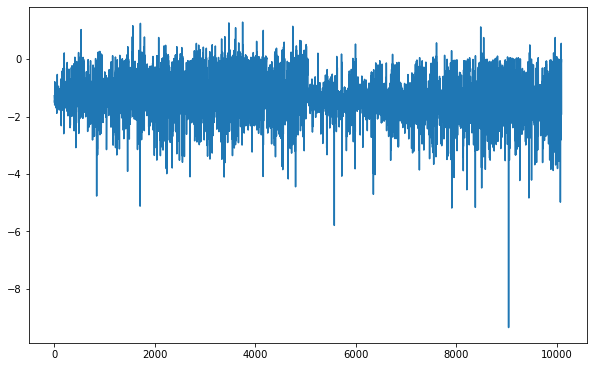

In [392]:
plt.plot(x)

In [382]:
compute_z(mode_22, gamma_mode_22[8000])

1.6076399225935498 1.7017467013134844 2.7357959351734387 -66.00000000000043


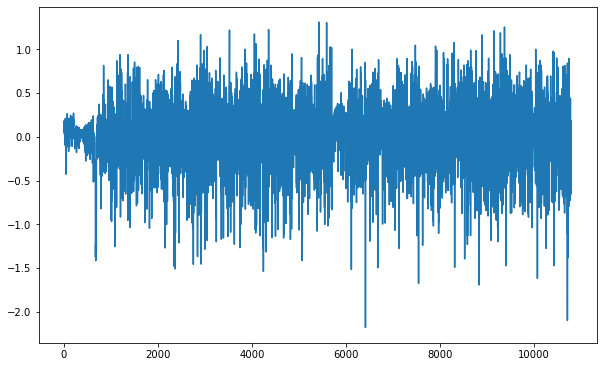

In [383]:
plt.plot(gamma_mode_22[8000])
# plt.plot(gamma_mode15[400], alpha=0.5)

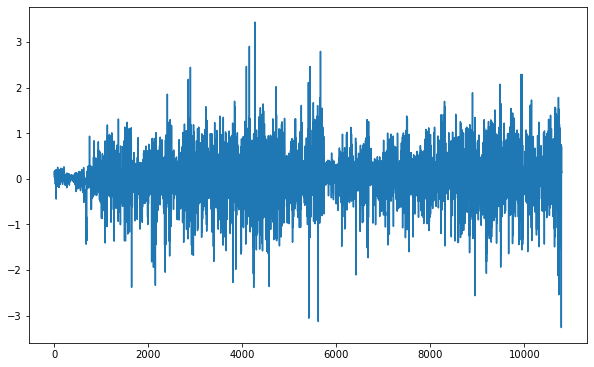

In [380]:
plt.plot(gamma_mode_22[10000])
# plt.plot(gamma_mode15[400], alpha=0.5)

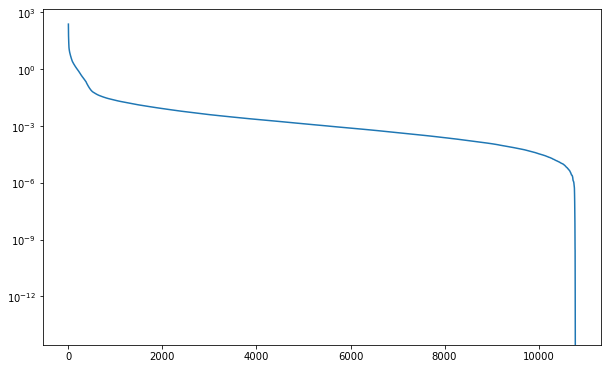

In [378]:
A_B = mode_22
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [385]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
x = gamma_mode_22[8000]
np.savetxt(f"{toLocation}/ten_letter_contact.dat", x[:690])
np.savetxt(f"{toLocation}/ten_letter_fourbody.dat", -x[690:])
np.savetxt(f"{toLocation}/ten_letter_all.dat", x)